In [27]:
!pip install kagglehub

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

#print("Path to dataset files:", path)
print(r"C:/Users/User/anaconda_projects/Lab_Assignment_2", path)


100%|██████████| 242M/242M [00:12<00:00, 19.6MB/s] 


Extracting files...
C:/Users/User/anaconda_projects/Lab_Assignment_2 C:\Users\User\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2


In [29]:
import pandas as pd

# Load the dataset
file_path = r"C:/Users/User/anaconda_projects/Lab_Assignment_2/Reviews.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows to understand structure
df_info = df.info()
df_head = df.head()

print(df_info)
print(df_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                        

In [30]:
# Step 1: Remove duplicates
df = df.drop_duplicates()

# Step 2: Drop rows with missing values in important fields
df = df.dropna(subset=['ProfileName', 'Summary', 'Text'])

# Step 3: Convert 'Time' from Unix timestamp to datetime
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Step 4: Remove rows where HelpfulnessDenominator is 0 (to avoid division by zero)
df = df[df['HelpfulnessDenominator'] != 0]

# Step 5: Keep only relevant columns
df_cleaned = df[['Score', 'Summary', 'Text', 'Time']].copy()

# Display info
print(df_cleaned.info())
print(df_cleaned.head())


<class 'pandas.core.frame.DataFrame'>
Index: 298371 entries, 0 to 568452
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Score    298371 non-null  int64         
 1   Summary  298371 non-null  object        
 2   Text     298371 non-null  object        
 3   Time     298371 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 11.4+ MB
None
    Score                          Summary  \
0       5            Good Quality Dog Food   
2       4            "Delight" says it all   
3       2                   Cough Medicine   
8       5                       Yay Barley   
10      5  The Best Hot Sauce in the World   

                                                 Text       Time  
0   I have bought several of the Vitality canned d... 2011-04-27  
2   This is a confection that has been around a fe... 2008-08-18  
3   If you are looking for the secret ingredient i... 2011-06-13  

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Use only the "Text" column for feature extraction
texts = df_cleaned['Text']

# 1. Bag-of-Words
bow_vectorizer = CountVectorizer(max_features=5000)  # limit to top 5000 words
X_bow = bow_vectorizer.fit_transform(texts)

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(texts)

# Display shape to confirm success
print("Bag-of-Words shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)


Bag-of-Words shape: (298371, 5000)
TF-IDF shape: (298371, 5000)


In [32]:
from textblob import TextBlob

# Simple sentiment labeling function
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply to your cleaned dataset
df_cleaned['Sentiment_Lexicon'] = df_cleaned['Text'].apply(get_sentiment)

# Check distribution
print(df_cleaned['Sentiment_Lexicon'].value_counts())


Sentiment_Lexicon
positive    256644
negative     36742
neutral       4985
Name: count, dtype: int64


In [33]:
def score_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df_cleaned['Sentiment_Label'] = df_cleaned['Score'].apply(score_to_sentiment)


In [34]:
from sklearn.model_selection import train_test_split

X = df_cleaned['Text']
y = df_cleaned['Sentiment_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))


D:\AnacondaNavigator\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.77      0.74      0.75     11686
     neutral       0.52      0.21      0.30      4889
    positive       0.89      0.96      0.92     43100

    accuracy                           0.85     59675
   macro avg       0.73      0.63      0.66     59675
weighted avg       0.83      0.85      0.84     59675



Accuracy: 0.8523
Precision: 0.8334
Recall: 0.8523
F1-Score: 0.8362

Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.74      0.75     11686
     neutral       0.52      0.21      0.30      4889
    positive       0.89      0.96      0.92     43100

    accuracy                           0.85     59675
   macro avg       0.73      0.63      0.66     59675
weighted avg       0.83      0.85      0.84     59675



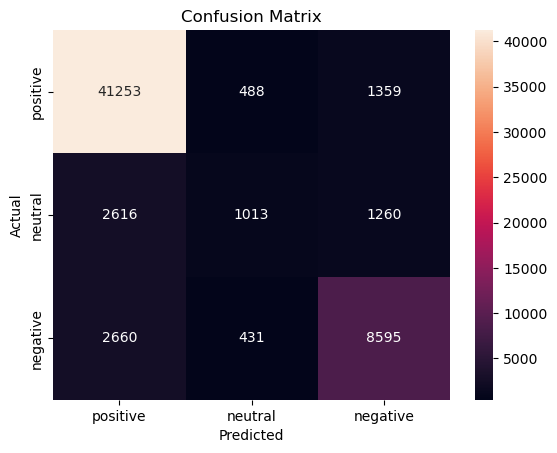

In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Full report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [38]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))


Naive Bayes:
               precision    recall  f1-score   support

    negative       0.83      0.37      0.51     11686
     neutral       0.75      0.00      0.00      4889
    positive       0.78      0.99      0.87     43100

    accuracy                           0.79     59675
   macro avg       0.79      0.45      0.46     59675
weighted avg       0.79      0.79      0.73     59675



In [39]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM:\n", classification_report(y_test, y_pred_svm))


SVM:
               precision    recall  f1-score   support

    negative       0.76      0.75      0.75     11686
     neutral       0.60      0.16      0.26      4889
    positive       0.89      0.96      0.92     43100

    accuracy                           0.85     59675
   macro avg       0.75      0.63      0.64     59675
weighted avg       0.84      0.85      0.83     59675



In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

## Discussion
# Muhammad Aqhmal Bin Abdul Hadi (IS01082817)
# Rizwan Bin Mohd Zaini (IS01083529)
#While doing the sentiment analysis, we found out that each model has its own strengths and weaknesses, in which each is suited to different use cases. For example, TextBlob is useful for quick sentiment analysis but unfortunately lacks accuracy for complex texts. Meanwhile, Logistic Regression and Naive Bayes are simple models that work well with linearly separable data but they may struggle with more complex relationships. However, SVM and Random Forest are more robust and can handle non-linear relationships better but they come with higher require more tuning. In summary, TextBlob,Logistic Regression and Naive Bayers is good for simple cases, while SVM and Random Forest can handle this sentiment analysis well.

